# Final Project - Reinforcements Learning 

---
<br>

### Name and ID:
Student 1: Nadav Shaked 312494925
<br>
Student 2: Michael Glustein 203929500
<br><br>
# Goodluck!

In [ ]:
#@title Select mode
MODE = "Debug" #@param ["Debug", "Presentation"]
WORKSPACE = '/content/drive/MyDrive/Colab Notebooks/RL/Final_Project/' #@param


## Installs and Imports

In [ ]:
!apt-get update
!pip install highway-env
!pip install git+https://github.com/DLR-RM/stable-baselines3
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git 2> /dev/null
!git clone https://github.com/avivg7/highway-config.git

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [817 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/ma

In [ ]:
import gym
import highway_env
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
from tqdm.notebook import trange
from utils import record_videos, show_videos
import numpy as np
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import io
import base64
import os
import random
import matplotlib.pyplot as plt
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import json
import ast
%load_ext tensorboard
%matplotlib inline

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Util functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_action_with_probability(action, n_actions, probability):
  return action if np.random.random() > probability else np.random.randint(0, n_actions)

def update_exploration_probability(curr_proba, proba_decay):
  return curr_proba * proba_decay

def reject_outliers(data, m=2):
    data[abs(data - np.mean(data)) > m * np.std(data)] = 0

In [ ]:
MODEL_DIR = WORKSPACE + 'saved_models/'
CONFIG_DIR = WORKSPACE + 'config/'

In [ ]:
# ============================================
file = open('/content/highway-config/config_ex1.txt', 'r')
contents = file.read()
config1 = ast.literal_eval(contents)
file.close()
# ============================================
file = open('/content/highway-config/config_ex2.txt', 'r')
contents = file.read()
config2 = ast.literal_eval(contents)
file.close()
# ============================================
file = open('/content/highway-config/config_ex3.txt', 'r')
contents = file.read()
config3 = ast.literal_eval(contents)
file.close()
# ============================================
file = open('/content/highway-config/config_ex4.txt', 'r')
contents = file.read()
config4 = ast.literal_eval(contents)
file.close()
# ============================================

# MODELS

In [ ]:
#@title Global params
STOCHASTIC_POLICY = 0.15  #@param {type:"number"}
ITERATIONS = 5000  #@param {type:"number"}
MAX_STEPS_PER_EPISODE = 200 #@param {type:"number"}

In [ ]:
#@title Training params
REPLAY_MEMORY_SIZE = 10000  #@param {type:"number"}
MIN_REPLAY_MEMORY_SIZE =  1000#@param {type:"number"}
MINIBATCH_SIZE = 64 #@param {type:"number"}

LEARNING_RATE = 1e-4 #@param {type:"number"}
DISCOUNT = 0.99 #@param {type:"number"}
INITIAL_EXPLORATION_PROBABILITY = 0.2 #@param {type:"number"}
EXPLORATION_PROBABILITY_DECAY = 0.99  #@param {type:"number"}
UPDATE_EXPLORATION = 20 #@param {type:"number"}

SAVE_MODEL_EVERY = 25 #@param {type:"number"}


## Base Model

In [ ]:
from tqdm import tqdm
from collections import namedtuple, deque

np.random.seed(0)

Transition = namedtuple('Transition',
                        ['state', 'action', 'reward', 'done', 'next_state'])

In [ ]:
from tensorflow.keras.optimizers import Adam

class BaseModel:
  def _init__(self, *args, **kwargs):
    raise NotImplementedError

  def train(self,  *args, **kwargs):
    raise NotImplementedError

  def evaluate(self,  *args, **kwargs):
    raise NotImplementedError

  def update_replay_memory(self, transition):
    self.replay_memory.append(transition)
    
  def save(self):
    self._save_model_weights()
    if MODE == "Debug":
      np.save(MODEL_DIR + f'{self.file}_loss.npy', self.loss_history)
      np.save(MODEL_DIR + f'{self.file}_reward.npy', self.rewards_history)
    print('Save successful')

  def load(self):
    if not self.should_load:
      print('NOTICE! Did not load model. Will overwrite!')
      return
    self._load_model_weights()
    if MODE == "Debug":
      self.loss_history = np.load(MODEL_DIR + f'{self.file}_loss.npy')
      self.rewards_history = np.load(MODEL_DIR + f'{self.file}_reward.npy')
    print('Load successful')

  def plot(self, skip):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    l1 = ax1.plot(np.array(range(0, len(self.loss_history) * skip, skip)) + 1, self.loss_history, color='red', label='loss')
    ax1.tick_params(axis='y', labelcolor='red')
    l2 = ax2.plot(np.array(range(0, len(self.rewards_history) * skip, skip)) + 1, self.rewards_history, color='green', label='reward')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_xlabel("# training iterations")
    ax1.set_ylabel("loss")
    ax2.set_ylabel("rewards sum")
    lines = l1 + l2
    ax1.legend(lines, [l.get_label() for l in lines], loc=0)
    plt.show()

  def run(self, num_of_iters):
    steps_per_iter = []
    rewards_per_iter = []
    for _ in tqdm(range(num_of_iters)):
      steps, rewards = self.run_single_iteration()
      steps_per_iter.append(steps)
      rewards_per_iter.append(rewards)

    # plot
    fig, ax1 = plt.subplots()
    l1 = ax1.plot(np.array(range(len(steps_per_iter))), np.array(steps_per_iter), color='red', label='steps')
    ax1.tick_params(axis='y', labelcolor='red')
    ax2 = ax1.twinx()
    l2 = ax2.plot(np.array(range(len(rewards_per_iter))), np.array(rewards_per_iter), color='green', label='rewards')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.set_xlabel("# of Iterations")
    ax1.set_ylabel("Num of Steps")
    ax2.set_ylabel("Sum of Rewards")
    lines = l1 + l2
    ax1.legend(lines, [l.get_label() for l in lines], loc=0)
    plt.show()

    print(f"On average the agent ran {sum(steps_per_iter) / len(steps_per_iter)} steps an iteration with sum of rewards of {sum(rewards_per_iter) / len(rewards_per_iter)}")


## DQN

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.models import load_model, clone_model


UPDATE_TARGET_VAL = 10


class DQN(BaseModel):
  def __init__(self, env, filename, lr, gamma=0.99, should_load=True):
    self.env = env
    self.file = filename
    self.lr = lr
    self.gamma = gamma
    self.should_load = should_load
    self.model = self.create_model()
    self.target_model = self.create_model()
    self.update_target_model()
    self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
    self.loss_history = np.array([])
    self.rewards_history = np.array([])

  def create_model(self):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=self.env.observation_space.shape,
                     data_format='channels_first'))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(1, 1), activation="relu"))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(self.env.action_space.n, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=self.lr), loss="mse", metrics=['accuracy'])
    return model

  def update_target_model(self):
    self.target_model.set_weights(self.model.get_weights())
    self.update_target_counter = 0

  def get_actions_q(self, state):
    return self.model.predict(np.array(state).reshape(-1, *state.shape) / 255)[0]

  def _train(self):
    if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
      return

    minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
    curr_states = np.array([transition.state for transition in minibatch]) / 255
    curr_q_list = self.model.predict(curr_states)
    new_states = np.array([transition.next_state for transition in minibatch]) / 255
    future_q_list = self.target_model.predict(new_states)

    X, Y = [], []
    for idx, transition in enumerate(minibatch):
      q = transition.reward if transition.done else transition.reward + self.gamma * np.max(future_q_list[idx]) 
      curr_q_list[idx][transition.action] = q
      X.append(transition.state)
      Y.append(curr_q_list[idx])

    self.model.fit(np.array(X) / 255, np.array(Y), batch_size=MINIBATCH_SIZE, verbose=0)

  def train(self, override_env=None):
    epsilon = INITIAL_EXPLORATION_PROBABILITY

    for iter in tqdm(range(ITERATIONS)):
      if override_env:
        self.env = override_env

      curr_state = self.env.reset()
      done = False
      steps = 0
      sum_rewards = 0

      while not done and steps < MAX_STEPS_PER_EPISODE:
        steps += 1
        action = np.argmax(self.get_actions_q(curr_state))
        action = get_action_with_probability(action, self.env.action_space.n, epsilon)
        action = get_action_with_probability(action, self.env.action_space.n, STOCHASTIC_POLICY)
        observation, reward, done, _ = self.env.step(action)
        transition = Transition(curr_state, action, reward, done, observation)
        self.update_replay_memory(transition)
        self._train()     

        curr_state = observation
        sum_rewards += reward

      if iter % UPDATE_TARGET_VAL == 0:
        self.update_target_model()

      if iter % UPDATE_EXPLORATION == 0:
        epsilon = update_exploration_probability(epsilon, EXPLORATION_PROBABILITY_DECAY)
      
      if iter % SAVE_MODEL_EVERY == 0 and self.model.history:
        self.loss_history = np.append(self.loss_history, self.model.history.history.get('loss', [0])[0])
        self.rewards_history = np.append(self.rewards_history, sum_rewards)
        self.save()

  def _save_model_weights(self):
    self.model.save_weights(MODEL_DIR + f'{self.file}.h5')

  def _load_model_weights(self):
    self.model.load_weights(MODEL_DIR + f'{self.file}.h5')
    self.target_model.load_weights(MODEL_DIR + f'{self.file}.h5')

  def run_single_iteration(self):
    curr_state = self.env.reset()
    done = False
    rewards = 0
    steps = 0
    while not done and steps < MAX_STEPS_PER_EPISODE:
      steps += 1
      action = np.argmax(self.get_actions_q(curr_state))
      action = get_action_with_probability(action, self.env.action_space.n, 0.15)
      observation, reward, done, _ = self.env.step(action)
      rewards += reward
      curr_state = observation
    return steps, rewards

## DDQN

In [ ]:
class DDQN(DQN):
  
  def _train(self):
    if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

    minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

    curr_states = np.array([transition.state for transition in minibatch]) / 255
    curr_q_list = self.model.predict(curr_states)

    new_curr_states = np.array([transition.next_state for transition in minibatch]) / 255
    future_q_a_list = self.model.predict(new_curr_states)
    future_q_b_list = self.target_model.predict(new_curr_states)

    X, Y = [], []
    for idx, transition in enumerate(minibatch):
      
      q = transition.reward if transition.done else \
       transition.reward + self.gamma * future_q_b_list[idx][np.argmax(future_q_a_list[idx])] 
      curr_q_list[idx][transition.action] = q

      X.append(transition.state)
      Y.append(curr_q_list[idx])

      self.model.fit(np.array(X) / 255, np.array(Y), batch_size=MINIBATCH_SIZE, verbose=0)

## D3QN

In [ ]:
from keras.layers import Lambda
import keras.backend as K

class D3QN(DDQN):

  def create_model(self):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=self.env.observation_space.shape,
                     data_format='channels_first'))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(1, 1), activation="relu"))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(self.env.action_space.n + 1, activation='linear'))
    model.add(Lambda(lambda i: K.expand_dims(i[:,0],-1) + i[:,1:] - K.mean(i[:,1:], keepdims=True), output_shape=self.env.action_space.n))

    model.compile(optimizer=Adam(learning_rate=self.lr), loss="mse", metrics=['accuracy'])
    return model


## A2C

In [ ]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, Flatten, Dense, Input, Add


class Actor:
  def __init__(self, env, lr):
    self.env = env
    self.lr = lr
    self.model = self.create_model()

  def create_model(self):
    state_input = Input(shape=self.env.observation_space.shape)
    conv1 = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=self.env.observation_space.shape,
                     data_format='channels_first')(state_input)
    conv2 = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), activation="relu")(conv1)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu")(conv2)
    flatten = Flatten()(conv3)
    dense = Dense(512, activation="relu")(flatten)
    output = Dense(self.env.action_space.n, activation='softmax')(dense)
    model = Model(inputs=state_input, outputs=output)
    model.compile(optimizer='adam', loss="mse")
    return model

  def train(self, transition, reward, pred):
    state = np.array(transition.state).reshape(-1, *transition.state.shape) / 255
    advantage = reward - pred 
    with tf.GradientTape() as tape:
      logit = self.model(state, training=True)
      action = tf.cast(transition.action, tf.int32)
      ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      loss = ce_loss(action, logit, sample_weight=tf.stop_gradient(advantage))
    grads = tape.gradient(loss, self.model.trainable_variables)
    print(grads)
    return tf.keras.optimizers.Adam(self.lr).apply_gradients(zip(grads, self.model.trainable_variables))

class Critic:
  def __init__(self, env, lr):
    self.env = env
    self.lr = lr
    self.model = self.create_model()

  def create_model(self):
    state_input = Input(shape=self.env.observation_space.shape)
    conv1 = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=self.env.observation_space.shape,
                     data_format='channels_first')(state_input)
    conv2 = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), activation="relu")(conv1)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu")(conv2)
    flatten = Flatten()(conv3)
    dense_state = Dense(512)(flatten)

    action_input = Input(shape=self.env.action_space.n)
    dense_action = Dense(512)(action_input)

    action_state = Add()([dense_state, dense_action])
    dense = Dense(24, activation='relu')(action_state)
    output = Dense(1, activation='softmax')(dense)
    model = Model(inputs=[state_input, action_input], outputs=output)
    model.compile(optimizer='adam', loss="mse")
    return model

  def train(self, transition, reward, pred):
    state = np.array(transition.state).reshape(-1, *transition.state.shape) / 255
    with tf.GradientTape() as tape:
      loss = tf.keras.losses.MeanSquaredError()(tf.stop_gradient(reward), pred)
    grads = tape.gradient(loss, self.model.trainable_variables)
    return tf.keras.optimizers.Adam(self.lr).apply_gradients(zip(grads, self.model.trainable_variables))


class A2C(BaseModel):
  def __init__(self, env, filename, lr=0.0001, gamma=0.99, should_load=True):
    self.env = env
    self.file = filename
    self.gamma = gamma
    self.should_load = should_load

    self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
    self.actor = Actor(env, lr)
    self.critic = Critic(env, lr)

    self.loss_history = np.array([])
    self.reward_history = np.array([])   

  def train(self):
    epsilon = INITIAL_EXPLORATION_PROBABILITY
    self.load()
    
    for iter in tqdm(range(ITERATIONS)):
        curr_state = self.env.reset()
        done = False
        sum_rewards = 0
        steps = 0

        while not done and steps < MAX_STEPS_PER_EPISODE:
          action_probs = self.actor.model.predict(np.array(curr_state).reshape(-1, *curr_state.shape) / 255)
          action = np.random.choice(np.arange(self.env.action_space.n), 1, p=action_probs.ravel())[0]
          action = get_action_with_probability(action, env.action_space.n, epsilon)
          action = get_action_with_probability(action, self.env.action_space.n, STOCHASTIC_POLICY)
          observation, reward, done, _ = self.env.step(action)
          transition = Transition(curr_state, action, reward, done, observation)
          model.update_replay_memory(transition)
          curr_state = observation
          sum_rewards += reward
          steps += 1

        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
          continue

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        for transition in minibatch:
          state = np.array(transition.state).reshape(-1, *transition.state.shape) / 255
          new_state = np.array(transition.next_state).reshape(-1, *transition.next_state.shape) / 255
          target_action = self.actor.model.predict(new_state)
          future_reward = self.critic.model.predict([new_state, target_action])[0][0]
          reward = np.array(transition.reward) if transition.done else transition.reward + self.gamma * future_reward
          pred = self.critic.model([state, self.actor.model.predict(state)], training=True)
          self.actor.train(transition, reward, pred)
          self.critic.train(transition, reward, pred)

        if iter % UPDATE_EXPLORATION == 0:
          epsilon = update_exploration_probability(epsilon, EXPLORATION_PROBABILITY_DECAY)
        
        if iter % SAVE_MODEL_EVERY == 0 and iter != 0:
          self.loss_history = np.append(self.loss_history, self.actor.model.history.history.get('loss', [0])[0])
          self.rewards_history = np.append(self.rewards_history, sum_rewards)
          self.save()

  def _save_model_weights(self):
    self.actor.model.save_weights(MODEL_DIR + f'{self.file}_actor_model.h5')
    self.critic.model.save_weights(MODEL_DIR + f'{self.file}_critic_model.h5')

  def _load_model_weights(self):
    self.actor.model.load_weights(MODEL_DIR + f'{self.file}_actor_model.h5')
    self.critic.model.load_weights(MODEL_DIR + f'{self.file}_critic_model.h5')


## DDPG

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Lambda, GaussianNoise, concatenate
from keras.initializers import RandomUniform


class OrnsteinUhlenbeckNoise(object):
  """ Ornstein-Uhlenbeck Noise - taken from internet"""
  def __init__(self, theta=0.15, mu=0, sigma=1, x0=0, dt=1e-2, n_steps_annealing=100, size=1):
    self.theta = theta
    self.sigma = sigma
    self.n_steps_annealing = n_steps_annealing
    self.sigma_step = - self.sigma / float(self.n_steps_annealing)
    self.x0 = x0
    self.mu = mu
    self.dt = dt
    self.size = size

  def generate(self, step):
    sigma = max(0, self.sigma_step * step + self.sigma)
    x = self.x0 + self.theta * (self.mu - self.x0) * self.dt + sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
    self.x0 = x
    return x


class Actor:
  def __init__(self, env, tau, lr):
    self.env = env
    self.tau = tau
    self.lr = lr

    self.model = self.create_model()
    self.target_model = self.create_model()

  def create_model(self):
    input = Input(shape=self.env.observation_space.shape)
    conv1 = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=env.observation_space.shape,
                     data_format='channels_first')(input)
    conv2 = Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation="relu")(conv1)
    conv3 = Conv2D(filters=64, kernel_size=(4, 4), strides=(1, 1), activation="relu")(conv2)
    flatten = Flatten()(conv3)

    f1 = Dense(512, activation='relu')(flatten)
    f1 = GaussianNoise(1.0)(f1)
    ff1 = Flatten()(f1)
    f2 = Dense(128, activation='relu')(ff1)
    f2 = GaussianNoise(1.0)(f2)
    output = Dense(self.env.action_space.n, activation='tanh', kernel_initializer=RandomUniform())(f2)
    output = output 
    model = Model(input, output)
    return model

  def optimizer(self):
    action_gradients = K.placeholder(shape=(None, self.env.action_space.n))
    params_grad = tf.gradients(self.model.output, self.model.trainable_weights, -action_gradients)
    grads = zip(params_grad, self.model.trainable_weights)
    return K.function([self.model.input, action_gradients], [tf.train.AdamOptimizer(self.lr).apply_gradients(grads)])

  def update_target_model(self):
    model_weights = self.model.get_weights()
    target_weight = self.target_model.get_weights()
    for i in range(len(model_weights)):
        target_weight[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weight[i]
    self.target_model.set_weights(target_weight)


class Critic:
  def __init__(self, env, tau, lr):
    self.env = env
    self.tau = tau
    self.lr = lr

    self.model = self.create_model()
    self.target_model = self.create_model()

  def create_model(self):
    state_input = Input(shape=self.env.observation_space.shape)
    conv1 = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=env.observation_space.shape,
                     data_format='channels_first')(state_input)
    conv2 = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), activation="relu")(conv1)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu")(conv2)
    flatten = Flatten()(conv3)
    dense = Dense(512, activation='relu')(conv3)
    flatten = Flatten()(dense)

    action_input = Input(shape=self.env.action_space.n)
    concat = concatenate([flatten, action_input])

    f1 = Dense(256, activation='relu')(concat)
    f2 = Dense(64, activation='relu')(f1)
    output = Dense(1, activation='linear', kernel_initializer=RandomUniform())(f2)
    model = Model([state_input, action_input], output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

  def action_gradients(self):
    return K.function([self.model.input[0], self.model.input[1]], K.gradients(self.model.output, [self.model.input[1]]))

  def update_target_model(self):
    model_weights = self.model.get_weights()
    target_weight = self.target_model.get_weights()
    for i in range(len(model_weights)):
        target_weight[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weight[i]
    self.target_model.set_weights(target_weight)


class DDPG:
  def __init__(self, env, gamma, tau, lr, filename, should_load=True):
    self.env = env
    self.gamma = gamma
    self.file = filename
    self.should_load = should_load
    self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
    self.actor = Actor(env, tau=tau, lr=lr/10)
    self.critic = Critic(env, tau=tau, lr=lr)
    self.loss_history = np.array([])
    self.rewards_history = np.array([])

  def update_replay_memory(self, transition):
    self.replay_memory.append(transition)

  def train(self, num_iters):
    epsilon = INITIAL_EXPLORATION_PROBABILITY
    self.load()
    
    for iter in tqdm(range(num_iters)):
        curr_state = self.env.reset()
        done = False
        sum_rewards = 0
        steps = 0
        noise = OrnsteinUhlenbeckNoise(size=self.env.action_space.n)

        while not done and steps < MAX_STEPS_PER_EPISODE:
          action = self.actor.model.predict(np.expand_dims(curr_state, axis=0) / 255)[0]
          action = np.clip(action+noise.generate(steps), -self.env.action_space.n, self.env.action_space.n)
          print(action)
          return
          action = get_action_with_probability(action, self.env.action_space.n, STOCHASTIC_POLICY)
          observation, reward, done, _ = self.env.step(action)
          transition = Transition(curr_state, action, reward, done, observation)
          model.update_replay_memory(transition)
          curr_state = observation
          sum_rewards += reward
          steps += 1

          if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            continue

          minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

          curr_states = np.array([transition.state for transition in minibatch]) / 255
          new_states = np.array([transition.next_state for transition in minibatch]) / 255
          q_values = self.critic.target_model.predict([new_states, self.actor.target_model.predict(new_states)])

          target = []
          for idx, transition in enumerate(minibatch):
            q = transition.reward if transition.done else transition.reward + self.gamma * q_values[idx]
            target.append(q)
          target = np.reshape(target, (MINIBATCH_SIZE, 1))

          actions = np.array([transition.action for transition in minibatch])
          self.critic.model.train_on_batch([curr_states, actions], target)

          predict_actions = self.actor.model.predict(curr_states)
          grads = self.critic.action_gradients([curr_states, predict_actions])

          self.actor.optimizer([curr_states, np.array(grads).reshape((-1, self.action_space.n))])
          self.actor.update_target_model()
          self.critic.update_target_model()

        if iter % UPDATE_EXPLORATION == 0:
          epsilon = update_exploration_probability(epsilon, EXPLORATION_PROBABILITY_DECAY)
        
        if iter % SAVE_MODEL_EVERY == 0 and iter != 0:
          self.loss_history = np.append(self.loss_history, self.actor.model.history.history.get('loss', [0])[0])
          self.rewards_history = np.append(self.rewards_history, sum_rewards)
          self.save()

  def save(self):
    self.actor.model.save_weights(MODEL_DIR + f'{self.file}_actor_model.h5')
    self.critic.model.save_weights(MODEL_DIR + f'{self.file}_critic_model.h5')
    np.save(MODEL_DIR + f'{self.file}_loss.npy', self.loss_history)
    np.save(MODEL_DIR + f'{self.file}_reward.npy', self.rewards_history)
    print('Save successful')

  def load(self):
    if not self.should_load:
      print('NOTICE! Did not load model. Will overwrite!')
      return
    self.actor.model.load_weights(MODEL_DIR + f'{self.file}_actor_model.h5')
    self.actor.update_target_model()
    self.critic.model.load_weights(MODEL_DIR + f'{self.file}_critic_model.h5')
    self.critic.update_target_model()
    self.loss_history = np.load(MODEL_DIR + f'{self.file}_loss.npy')
    self.rewards_history = np.load(MODEL_DIR + f'{self.file}_reward.npy')
    print('Load successful')



## PPO

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Input
import keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

PPOTransition = namedtuple('PPOTransition',
                        ['state', 'action', 'reward', 'done', 'next_state', 'prediction'])

class PPO(BaseModel):
  def __init__(self, env, filename, lr=0.0001, clip_loss=0.2, entropy_loss=0.0005, gamma=0.99, should_load=True):
    self.env = env
    self.file = filename
    self.lr = lr
    self.clip_loss = clip_loss
    self.entropy_loss = entropy_loss
    self.gamma = gamma
    self.should_load = should_load

    self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
    self.actor = self.create_actor_model(env)
    self.critic = self.create_critic_model(env)
    
    self.loss_history = np.array([])
    self.rewards_history = np.array([])

  def create_actor_model(self, env):
    state_input = Input(shape=env.observation_space.shape)
    conv1 = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=env.observation_space.shape,
                     data_format='channels_first')(state_input)
    conv2 = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), activation="relu")(conv1)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu")(conv2)
    flatten = Flatten()(conv3)
    dense_state = Dense(512, activation="relu")(flatten)
    output = Dense(env.action_space.n, activation='softmax')(dense_state)

    advantage_input = Input(shape=(1,))
    old_pred_input = Input(shape=(self.env.action_space.n,))

    model = Model(inputs=[state_input, advantage_input, old_pred_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=self.lr), loss=[self.ppo_loss(advantage=advantage_input,
                                                        old_pred=old_pred_input)])
    return model

  def create_critic_model(self, env):
    state_input = Input(shape=env.observation_space.shape)
    conv1 = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                     activation="relu", input_shape=env.observation_space.shape,
                     data_format='channels_first')(state_input)
    conv2 = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), activation="relu")(conv1)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu")(conv2)
    flatten = Flatten()(conv3)
    dense_state = Dense(512)(flatten)
    output = Dense(1, activation='softmax')(dense_state)

    model = Model(inputs=[state_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=self.lr), loss="mse")
    return model

  def ppo_loss(self, advantage, old_pred):
    def loss(y_true, y_pred):
      prob = y_true * y_pred
      old_prob = y_true * old_pred
      r = prob/(old_prob + 1e-10)
      return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1-self.clip_loss, max_value=1+self.clip_loss) * advantage) + self.entropy_loss * (prob * K.log(prob + 1e-10)))
    return loss

  def get_action_and_pred(self, curr_state):
      prediction = self.actor.predict([np.array(curr_state).reshape(-1, *curr_state.shape) / 255, 
                                  np.zeros((1, 1)),
                                  np.zeros((1, self.env.action_space.n))]) # for prediction send zeros
      action = np.argmax(prediction[0])
      return action, prediction

  def train(self, override_env=None):
    epsilon = INITIAL_EXPLORATION_PROBABILITY
    
    for iter in tqdm(range(ITERATIONS)):
        if override_env:
          self.env = override_env
        curr_state = self.env.reset()
        done = False
        sum_rewards = 0
        steps = 0

        while not done and steps < MAX_STEPS_PER_EPISODE:
          action, pred = self.get_action_and_pred(curr_state)
          action = get_action_with_probability(action, env.action_space.n, epsilon)
          action = get_action_with_probability(action, self.env.action_space.n, STOCHASTIC_POLICY)
          observation, reward, done, _ = self.env.step(action)
          transition = PPOTransition(curr_state, action, reward, done, observation, pred)
          model.update_replay_memory(transition)
          curr_state = observation
          sum_rewards += reward
          steps += 1

          if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            continue

          minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

          for transition in minibatch:
            state = np.array(transition.state).reshape(-1, *transition.state.shape) / 255
            pred_val = self.critic.predict(state)
            reward = np.array([transition.reward]) if transition.done else transition.reward + self.gamma * pred_val
            advantage = transition.reward - pred_val
            action_output = np.zeros(env.action_space.n)
            action_output[transition.action] = 1
            actor_loss = self.actor.fit([state, advantage, transition.prediction], np.float32([action_output]), verbose=0)
            critic_loss = self.critic.fit(state, reward, verbose=0)

        if iter % UPDATE_EXPLORATION == 0:
          epsilon = update_exploration_probability(epsilon, EXPLORATION_PROBABILITY_DECAY)
        
        if iter % SAVE_MODEL_EVERY == 0 and self.actor.history:
          self.loss_history = np.append(self.loss_history, self.actor.history.history.get('loss', [0])[0])
          self.rewards_history = np.append(self.rewards_history, sum_rewards)
          self.save()

  def _save_model_weights(self):
    self.actor.save_weights(MODEL_DIR + f'{self.file}_actor_model.h5')
    self.critic.save_weights(MODEL_DIR + f'{self.file}_critic_model.h5')
  
  def _load_model_weights(self):
    self.actor.load_weights(MODEL_DIR + f'{self.file}_actor_model.h5')
    self.critic.load_weights(MODEL_DIR + f'{self.file}_critic_model.h5')

  def run_single_iteration(self):
    curr_state = self.env.reset()
    done = False
    steps = 0
    rewards = 0
    while not done and steps < MAX_STEPS_PER_EPISODE:
      steps += 1
      action, _ = model.get_action_and_pred(curr_state)
      action = get_action_with_probability(action, self.env.action_space.n, STOCHASTIC_POLICY)
      observation, reward, done, _ = self.env.step(action)
      rewards += reward
      curr_state = observation
    return steps, rewards

# Trainer

In [ ]:
#@title Select Algorithm
EX = "ex2" #@param ["ex1", "ex2", "ex3"]
ALGORITHM = "D3QN" #@param ["DQN", "DDQN", "D3QN", "PPO"]
ENV = "highway-fast-v0" #@param ["highway-fast-v0", "merge-v0", "roundabout-v0"]
should_load = "True" #@param ["True", "False"]


In [ ]:
# LOAD
print(f"Running {ALGORITHM} on {EX}\n##########")

config = None
if EX == "ex1":
  config = config1
elif EX == "ex2":
  config = config2
elif EX == "ex3":
  config = config3

env = gym.make(ENV)
env.configure(config)
env.reset()

MODEL_NAME = ALGORITHM + '_' + EX

model = None
should_load = True if should_load == "True" else False

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=should_load)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=should_load)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=should_load)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=should_load)

model.load()

Running D3QN on ex2
##########
Load successful


In [ ]:
# TRAIN
if EX == "ex3":
  highway_env = gym.make("highway-fast-v0")
  highway_env.configure(config)
  merge_env = gym.make("merge-v0")
  merge_env.configure(config)
  roundabout_env = gym.make("roundabout-v0")
  roundabout_env.configure(config)
  tmp_iters = ITERATIONS
  ITERATIONS = 500
  for env in [roundabout_env, merge_env, highway_env, roundabout_env, merge_env]:
    model.train(override_env=env)
    model.replay_memory = deque(REPLAY_MEMORY_SIZE)
  ITERATIONS = tmp_iters
else:
  model.train()

DDQN: Loss history + rewards

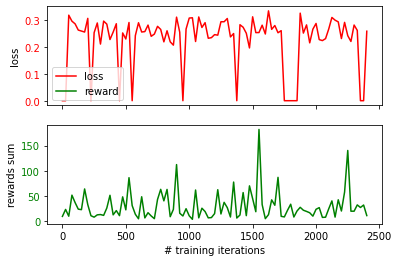

In [ ]:
model.plot(skip=SAVE_MODEL_EVERY)

D3QN: Loss history + rewards


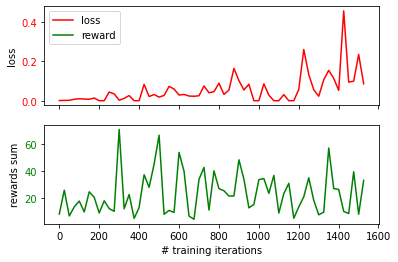

In [ ]:
reject_outliers(model.loss_history) # only run once to remove outliers
model.plot(skip=SAVE_MODEL_EVERY)

EX2 - D3QN: Loss history + rewards

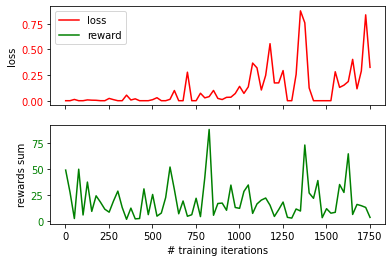

In [ ]:
model.plot(skip=SAVE_MODEL_EVERY)

EX3 - PPO: Loss history + rewards

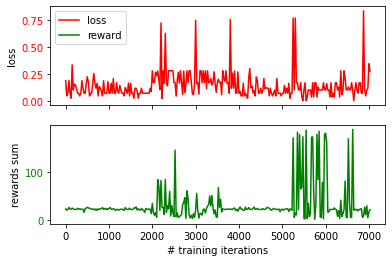

In [ ]:
model.plot(skip=SAVE_MODEL_EVERY)

# EX1 - Highway-Env - Grayscale Image - Easy


In [ ]:
#@title Select Algorithm
EX = "ex1" #@param ["ex1", "ex2", "ex3"]
ALGORITHM = "PPO" #@param ["DQN", "DDQN", "D3QN", "PPO"]
ITERS = 100 #@param {type:"number"}

DDQN - 100 iterations

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config1)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running DDQN on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [06:04<00:00,  3.65s/it]


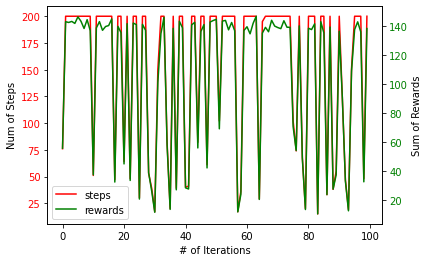

On average the agent ran 151.13 steps an iteration with sum of rewards of 106.05838782179698


In [ ]:
model.run(num_of_iters=ITERS)

D3QN - 100 iterations

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config1)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running D3QN on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


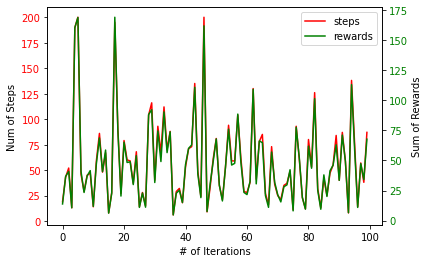

On average the agent ran 58.26 steps an iteration with sum of rewards of 47.78735094084966


In [ ]:
model.run(num_of_iters=ITERS)

PPO - 100 iterations

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config1)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running PPO on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


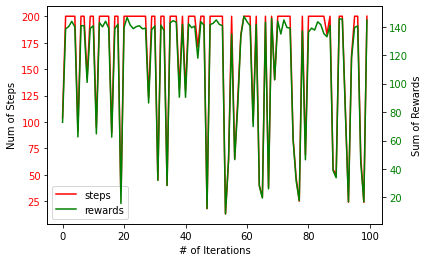

On average the agent ran 159.01 steps an iteration with sum of rewards of 112.04844550284672


In [ ]:
model.run(num_of_iters=ITERS)

# EX2 - Highway-Env - Grayscale Image - Medium

In [ ]:
#@title Select Algorithm
EX = "ex2" #@param ["ex1", "ex2", "ex3"]
ALGORITHM = "D3QN" #@param ["DQN", "DDQN", "D3QN", "PPO"]
ITERS = 100 #@param {type:"number"}

DDQN - 100 iterations

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config2)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running DDQN on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [09:04<00:00,  5.45s/it]


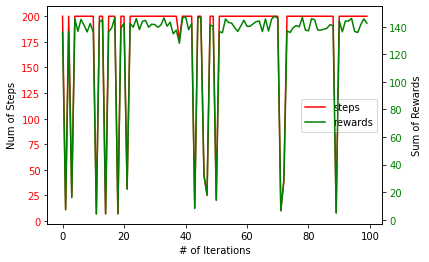

On average the agent ran 176.27 steps an iteration with sum of rewards of 124.48329736241945


In [ ]:
model.run(num_of_iters=ITERS)

D3QN - 100 iterations

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config2)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running D3QN on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [05:31<00:00,  3.31s/it]


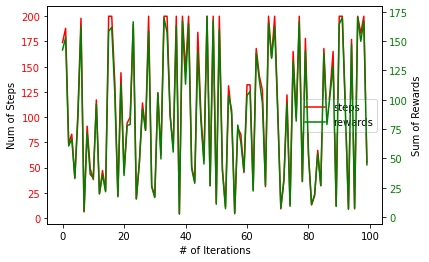

On average the agent ran 104.13 steps an iteration with sum of rewards of 85.08475542485805


In [ ]:
model.run(num_of_iters=ITERS)

PPO - 100 iterations

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config2)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running PPO on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [08:38<00:00,  5.18s/it]


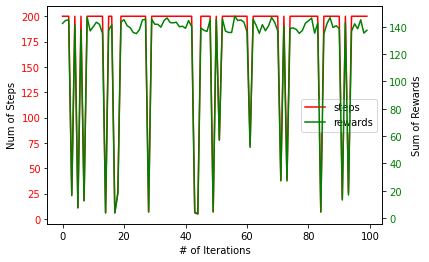

On average the agent ran 169.96 steps an iteration with sum of rewards of 119.76199278536829


In [ ]:
model.run(num_of_iters=ITERS)

# Ex3 - Super Highway Agent

In [ ]:
#@title Select Algorithm
EX = "ex3" #@param ["ex3"]
ALGORITHM = "D3QN" #@param ["D3QN", "PPO"]
ITERS = 100 #@param {type:"number"}

### Ex3 - Highway-Env

D3QN

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config3)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running D3QN on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


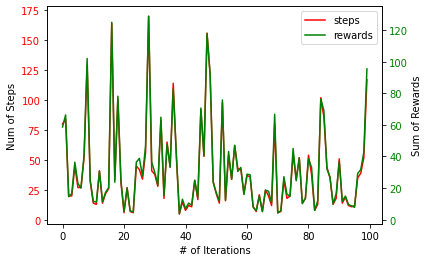

On average the agent ran 41.02 steps an iteration with sum of rewards of 31.990563218454316


In [ ]:
model.run(num_of_iters=ITERS)

PPO

In [ ]:
print(f"Running {ALGORITHM} on highway environment")
env = gym.make("highway-fast-v0")
env.configure(config3)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running PPO on highway environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


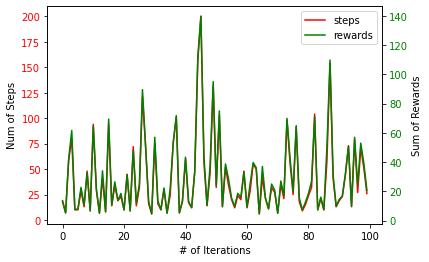

On average the agent ran 40.6 steps an iteration with sum of rewards of 30.12323364174321


In [ ]:
model.run(num_of_iters=ITERS)

### Ex3 - Merge-Env

In [ ]:
# For the following environmnets 50 steps is enough
MAX_STEPS_PER_EPISODE = 50 #@param {type:"number"}

D3QN

In [ ]:
print(f"Running {ALGORITHM} on merge environment")
env = gym.make("merge-v0")
env.configure(config3)
env.reset()
env = wrap_env(env)


MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()
model.run_single_iteration()
env.close()
show_video()

Running D3QN on merge environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


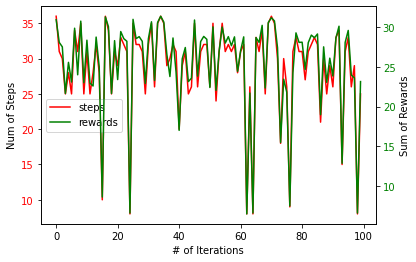

On average the agent ran 28.74 steps an iteration with sum of rewards of 25.334795045490164


In [ ]:
model.run(num_of_iters=ITERS)

PPO

In [ ]:
print(f"Running {ALGORITHM} on merge environment")
env = gym.make("merge-v0")
env.configure(config3)
env.reset()
env = wrap_env(env)


MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()
model.run_single_iteration()
env.close()
show_video()

Running PPO on merge environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


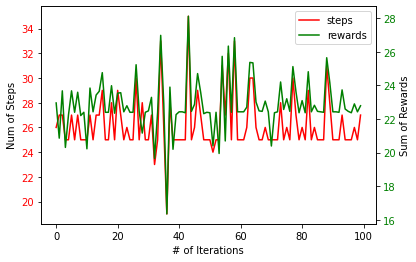

On average the agent ran 26.26 steps an iteration with sum of rewards of 22.853515350404138


In [ ]:
model.run(num_of_iters=ITERS)

### Ex3 - Roundabout-Env

D3QN

In [ ]:
print(f"Running {ALGORITHM} on roundabout environment")
env = gym.make("roundabout-v0")
env.configure(config3)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running D3QN on roundabout environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


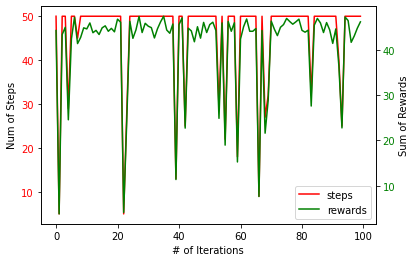

On average the agent ran 45.84 steps an iteration with sum of rewards of 41.08160000000002


In [ ]:
model.run(num_of_iters=ITERS)

PPO

In [ ]:
print(f"Running {ALGORITHM} on roundabout environment")
env = gym.make("roundabout-v0")
env.configure(config3)
env.reset()
env = wrap_env(env)

MODEL_NAME = ALGORITHM + '_' + EX
if MODE != "Debug":
  MODEL_NAME = EX + '_w/' + MODEL_NAME

model = None

if ALGORITHM == "DQN":
  model = DQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "DDQN":
  model = DDQN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "D3QN":
  model = D3QN(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)
elif ALGORITHM == "PPO":
  model = PPO(env, MODEL_NAME, lr=LEARNING_RATE, gamma=DISCOUNT, should_load=True)

model.load()

model.run_single_iteration()
env.close()
show_video()

Running PPO on roundabout environment
Load successful


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


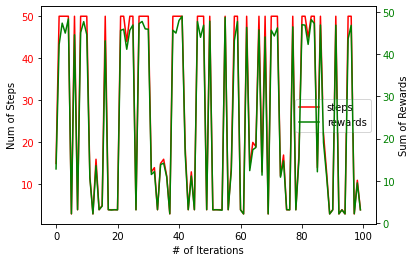

On average the agent ran 26.94 steps an iteration with sum of rewards of 24.559999999999977


In [ ]:
model.run(num_of_iters=ITERS)